In [1]:
import numpy as np
import pandas as pd
import spacy
import string
import random
import re

from collections import defaultdict
from collections import Counter

In [2]:
# import pytorch libraries
%matplotlib inline
import torch 
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

###### Load NFL Comments

In [3]:
r1 = pd.read_json('data/round1.json')
r2_3 = pd.read_json('data/round2_3.json')
r4_7 = pd.read_json('data/round4_7.json')
comments = pd.concat([r1, r2_3, r4_7])
comments.columns = ['Thread', 'User', 'Flair', 'Comment', 'Score', 'Awards', 'Time']

In [4]:
comments.Comment = comments.Comment.str.replace(r'http\S+', '')
comments.Comment = comments.Comment.str.replace('\n', ' ')

###### Clean Text and Create Vocab

In [5]:
nlp = spacy.load("en_core_web_sm")

In [6]:
stop_words = nlp.Defaults.stop_words

In [7]:
merge_ents = nlp.create_pipe("merge_entities")
nlp.add_pipe(merge_ents)

In [8]:
regex = re.compile('[^a-z ]')

In [9]:
def clean_text(row):
    text_list = [t.text.lower() for t in nlp(row)]
    text_list = [regex.sub('', w) for w in text_list]
    text_list = [text for text in text_list if text not in stop_words and len(text.strip()) > 2]
    return text_list

In [10]:
text = comments.Comment.apply(clean_text)
text = [comment for comment in text if len(comment) >= 7]

### CBOW

In [11]:
text_cbow = [seq[i-6:i+1] for seq in text for i in range(6, len(seq))]

In [12]:
text_cbow[:5]

[['love', 'pick', 'holy', 'shit', 'shockingly', 'book', 'picks'],
 ['booze', 'coming', 'know', 'boos', 'choose', 'believe', 'commissioner'],
 ['coming', 'know', 'boos', 'choose', 'believe', 'commissioner', 'told'],
 ['know', 'boos', 'choose', 'believe', 'commissioner', 'told', 'hammered'],
 ['goodell', 'sort', 'social', 'disorder', 'highlights', 'jerry', 'yacht']]

In [13]:
random.shuffle(text_cbow)

In [14]:
idx = len(text_cbow)
train, val = text_cbow[:int(idx*0.8)], text_cbow[int(idx*0.8):]

In [15]:
len(train), len(val), idx

(112189, 28048, 140237)

In [16]:
trn_vocab = [word for seq in train for word in seq]

In [17]:
word_ct = Counter(trn_vocab)

In [18]:
len(word_ct.keys())

23373

In [19]:
# Delete words that are very infrequent, < 10 instances
for word in list(word_ct):
    if word_ct[word] < 10:
        del word_ct[word]

In [20]:
len(word_ct.keys())

7044

In [21]:
# Label encode vocab words
vocab2idx = {'UNK': 0} # Intialize with unknown
words = ['UNK']
for word in word_ct:
    vocab2idx[word] = len(words)
    words.append(word)

In [22]:
def encode_seq(seq):
    return [vocab2idx.get(word, vocab2idx['UNK']) for word in seq]

In [23]:
train = [encode_seq(seq) for seq in train]
val = [encode_seq(seq) for seq in val]

In [24]:
len(train)

112189

In [25]:
class CBOWDataset(Dataset):
    def __init__(self, encoding):
        self.df = encoding

    def __len__(self):
        """ Length of the dataset """
        L = len(self.df)
        return L

    def __getitem__(self, idx):
        """ returns x[idx], y[idx] for this dataset
        
        x[idx] should be a numpy array of shape (4,)
        """
        x = self.df[idx][:2] + self.df[idx][3:]
        y = self.df[idx][2]
        return np.array(x), y 

In [26]:
dataset = CBOWDataset(train[:1])

In [27]:
x, y = dataset[0]

In [28]:
x, y

(array([1, 2, 4, 5, 0, 6]), 3)

In [106]:
class CBOW(nn.Module):
    def __init__(self, vocab_size, emb_size):
        super(CBOW, self).__init__()
        self.word_emb = nn.Embedding(vocab_size, emb_size)
        self.linear = nn.Linear(6 * emb_size, vocab_size)
        self.emb_size = emb_size
        
    def forward(self, x):
        x = self.word_emb(x) # N x 6 x emb_size
        x = x.view(-1, 6 * self.emb_size)
        x = self.linear(x)
        return x

In [107]:
V = len(words)
emb = 10

model = CBOW(vocab_size=V, emb_size=emb)
small_dl = DataLoader(dataset, batch_size=2)
x, y = next(iter(small_dl))

In [108]:
out = model(x)
out.size()

torch.Size([1, 7045])

In [109]:
len(train), len(val)

(112189, 28048)

In [110]:
train_ds = CBOWDataset(train)
valid_ds = CBOWDataset(val)
train_dl = DataLoader(train_ds, batch_size=10000, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=10000)

In [111]:
def val_metrics(model):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0
    for x, y in valid_dl:
        batch = y.shape[0]
        out = model(x.long())
        loss = F.cross_entropy(out, y)
        sum_loss += batch*(loss.item())
        total += batch
        pred = torch.max(out, dim=1)[1]
        correct += (pred == y).float().sum().item()
    val_loss = sum_loss/total
    val_acc = correct/total
    return val_loss, val_acc

In [112]:
def train_epocs(model, optimizer, epochs=10):
    prev_val_acc = 0
    for i in range(epochs):
        total_loss = 0
        total = 0
        model.train()
        for x, y in train_dl:
            y_hat = model(x.long())
            loss = F.cross_entropy(y_hat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += x.size(0)*loss.item()
            total += x.size(0)
        train_loss = total_loss/total
        val_loss, val_accuracy = val_metrics(model)
        
        print("train_loss %.3f val_loss %.3f val_accuracy %.3f" % (
            train_loss, val_loss, val_accuracy))
        
        # save model
#         if val_accuracy > prev_val_acc:
#             prev_val_acc = val_accuracy
#             path = "data/models/embedding_{0:.1f}.pth".format(100*val_accuracy) 
#             if val_accuracy > 0.12:
#                 save_model(model, path)
#                 print(path)

In [156]:
def set_learning_rate(optimizer, lr):
    """Changing learning rates without creating a new optimizer"""
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [178]:
model = CBOW(vocab_size=V, emb_size=5)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [179]:
train_epocs(model, optimizer, epochs=8)

train_loss 8.850 val_loss 8.587 val_accuracy 0.008
train_loss 8.236 val_loss 8.108 val_accuracy 0.029
train_loss 7.655 val_loss 7.715 val_accuracy 0.054
train_loss 7.268 val_loss 7.566 val_accuracy 0.061
train_loss 7.053 val_loss 7.490 val_accuracy 0.067
train_loss 6.907 val_loss 7.450 val_accuracy 0.074
train_loss 6.797 val_loss 7.433 val_accuracy 0.077
train_loss 6.709 val_loss 7.427 val_accuracy 0.080


In [180]:
set_learning_rate(optimizer, 0.0025)

In [181]:
train_epocs(model, optimizer, epochs=5)

train_loss 6.632 val_loss 7.425 val_accuracy 0.080
train_loss 6.613 val_loss 7.425 val_accuracy 0.080
train_loss 6.594 val_loss 7.425 val_accuracy 0.081
train_loss 6.576 val_loss 7.426 val_accuracy 0.081
train_loss 6.559 val_loss 7.427 val_accuracy 0.081


In [182]:
set_learning_rate(optimizer, 0.001)

In [183]:
train_epocs(model, optimizer, epochs=5)

train_loss 6.542 val_loss 7.428 val_accuracy 0.081
train_loss 6.535 val_loss 7.428 val_accuracy 0.082
train_loss 6.528 val_loss 7.429 val_accuracy 0.081
train_loss 6.522 val_loss 7.430 val_accuracy 0.082
train_loss 6.515 val_loss 7.431 val_accuracy 0.082


In [184]:
from annoy import AnnoyIndex

In [185]:
W = model.word_emb.weight
W = W.detach().numpy()
W.shape

(7045, 5)

In [187]:
t = AnnoyIndex(5, "euclidean")
for i in range(W.shape[0]):
    t.add_item(i, W[i])
t.build(5) # 10 trees
t.save('W.ann')

True

In [188]:
t = AnnoyIndex(5, "euclidean")
t.load('W.ann')
t.get_nns_by_item(1, 4)

[1, 1953, 2851, 2987]

In [189]:
def gen_nns(w, t=t, k=5):
    ind = vocab2idx[w]
    return [words[x] for x in t.get_nns_by_item(ind, k)]

In [190]:
gen_nns("world")

['world', 'search', 'magical', 'prone', 'eventual']

In [191]:
gen_nns("joe burrow")

['joe burrow', 'reportedly', 'dallas', 'cook', 'rams']

In [192]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [193]:
pca = PCA(n_components=2)

In [194]:
output = pca.fit_transform(W)

In [195]:
r1_players = [thread for thread in comments.Thread.unique() if thread.startswith('Round 1') or
             thread.startswith('Round 2')]
r1_players = [string[string.find(':') + 2 :string.find(',')] for string in r1_players]
r1_players = [clean_text(name) for name in r1_players]
r1_players = [name for sublist in r1_players for name in sublist]
r1_players = [name for name in r1_players if name in vocab2idx.keys()]

In [196]:
idx = [vocab2idx[name] for name in r1_players]

In [197]:
rev = {v:k for k,v in vocab2idx.items()}

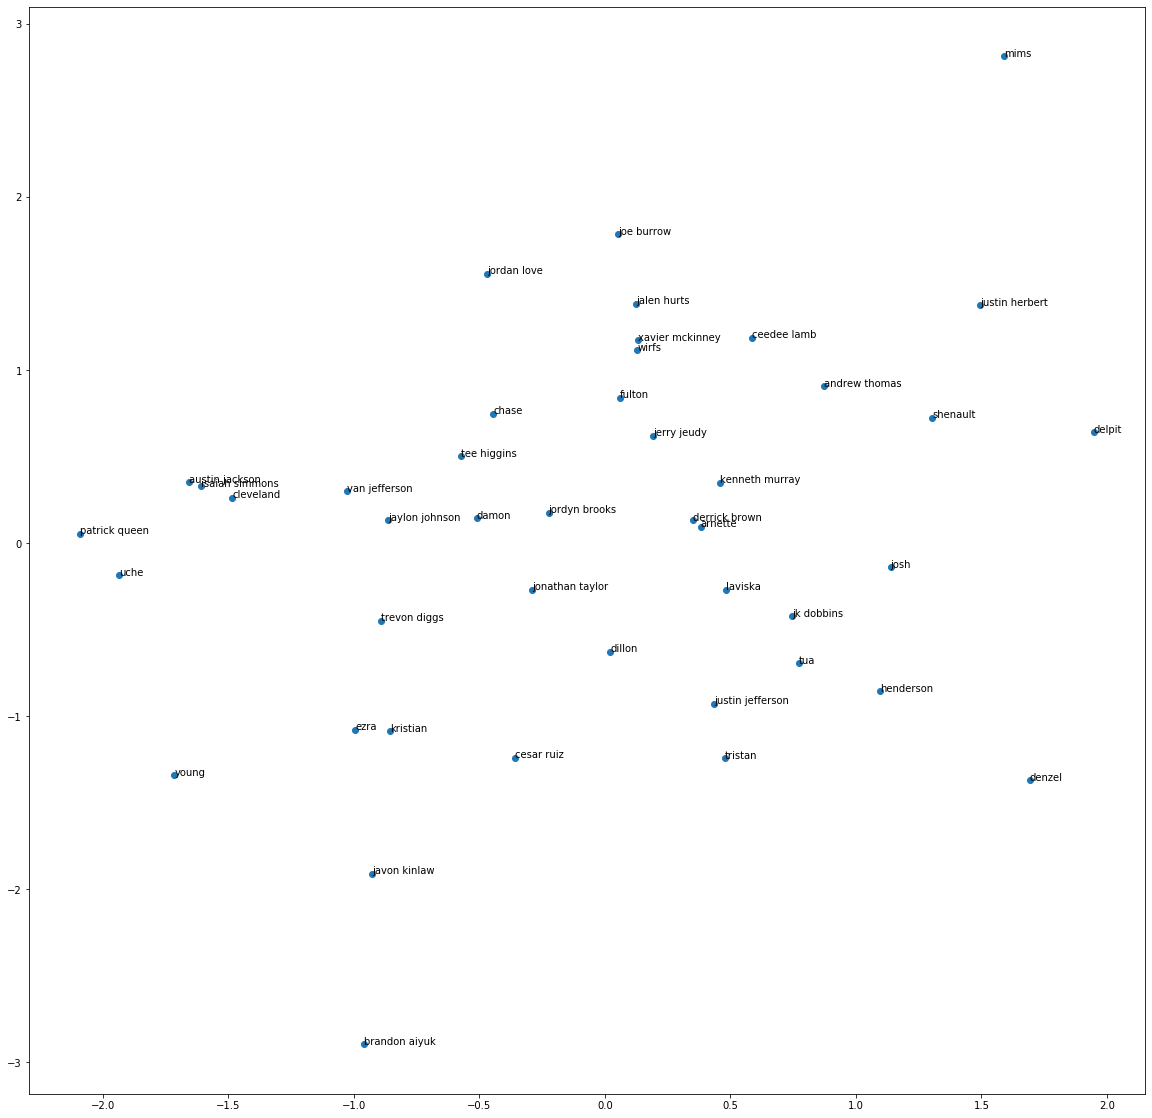

In [198]:
plt.figure(figsize=(20,20))
plt.scatter(output[idx,0], output[idx,1])

for i in idx:
    plt.annotate(rev[i], (output[i,0], output[i,1]))
    
plt.show()

### Skip-Gram

In [259]:
def skip_gram(word_list):
    word_window = [(word, word_list[max(idx - 2, 0): idx] + word_list[idx + 1: idx + 3]) \
                               for idx, word in enumerate(word_list)]
    skip_gram = [[center, neighbor] for (center, neighbors) in word_window for neighbor in neighbors] 
    return skip_gram

In [262]:
skip_gram_list = []
for row in text:
    row_skip_gram = skip_gram(row)
    skip_gram_list.extend(row_skip_gram)

In [263]:
len(skip_gram_list)

997268

In [265]:
skip_gram_list[:5]

[['love', 'pick'],
 ['love', 'holy'],
 ['pick', 'love'],
 ['pick', 'holy'],
 ['pick', 'shit']]

In [266]:
all_words = {w for gram in skip_gram_list for w in gram}

In [267]:
len(all_words)

24184

In [268]:
skip2idx = defaultdict(int)

In [269]:
for i, w in enumerate(all_words):
    skip2idx[w] = i

In [272]:
random.shuffle(skip_gram_list)

In [275]:
idx = len(skip_gram_list)
train, val = skip_gram_list[:int(idx*0.85)], skip_gram_list[int(idx*0.85):]

In [276]:
len(train), len(val)

(847677, 149591)

In [291]:
class SkipDataset(Dataset):
    def __init__(self, skip):
        self.df = skip

    def __len__(self):
        """ Length of the dataset """
        L = len(self.df)
        return L

    def __getitem__(self, idx):
        """ returns x[idx], y[idx] for this dataset
        
        x[idx] should be a numpy array of shape (4,)
        """
        x, y = skip2idx[self.df[idx][0]], skip2idx[self.df[idx][1]]
        return x, y

In [292]:
dataset = SkipDataset(train[:1])

In [295]:
x, y = dataset[0]
x, y

(19805, 15752)

In [ ]:
class SkipGram(nn.Module):
    def __init__(self, vocab_size, emb_size):
        super(SkipGram, self).__init__()
        self.word_emb = nn.Embedding(vocab_size, emb_size)
        self.linear = nn.Linear(vec_size, vocab_size)
        self.emb_size = emb_size
        
    def forward(self, x):
        x = self.word_emb(x) # N x 6 x emb_size
        x = x.view(-1, 6 * self.emb_size)
        x = self.linear(x)
        return x